<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Inversion_of_a_linear_filter_with_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust Inversion

Let $y[\cdot] = (u * h)[\cdot] + w [\cdot]$ where $h[\cdot]$ is the impulse response of a stable filter and $w[\cdot]$ some disturbance. We wish to reconstruct $u[\cdot]$ with a linear filter, i.e. $\hat{u}[\cdot] = (y * g)[\cdot] = ((u * h) * g)[\cdot] + (w * g) [\cdot]$. Now $g$ should be constructed such that it inverts $h$, but does not amplify the noise $w$. We propose in the frequency domain
$$G(z) = \frac{H^c(z)}{H(z)H^c(z) + \sigma^2}$$
with $\sigma > 0$ a parameter surpressing noise. Frequencies where $H(e^{i\Omega})$ is large are almost ideally reversed ($\sigma \ll |H(e^{i\Omega})|^2$) whereas for frequencies that are removed by the filter $h$ the inversion does not try to reconstruct their content since it likely stems from noise.

In [214]:
pip install pydsm

In [215]:
#several example signals

# n is a range type object describing the relevant domain, a describes the point where the step occurs
def unit_step(a, n):
    unit = []
    for sample in n:
        if sample<a:
            unit.append(0)
        else:
            unit.append(1)
    return(unit)

# n is a range type object describing the relevant domain, a describes the point where the pulse occurs
def unit_impulse(a, n):
    delta = []
    for sample in n:
        if sample == a:
            delta.append(1)
        else:
            delta.append(0)
              
    return delta

# n is a range type object describing the relevant domain, a describes the point where the ramp begins
def ramp(a, n):
    ramp = []
    for sample in n:
        if sample<a:
            ramp.append(0)
        else:
            ramp.append((sample-a)/4)
    return ramp

# n is a range type object describing the relevant domain, a describes the growth rate
def exponential(a, n):
    expo = []
    for sample in n:
        expo.append(np.exp(a/20 * sample))
    return (expo)

In [229]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pydsm.ft import idtft
#-------------------------------------------------------------------------------
#size of window to look at
nG = np.arange(-20, 20)

#read in parameters
signalG = "unit step"
aG = '1'
filterG = "low pass"
cutoffFrequencyG = np.pi/2
sigmaG = 1
def update_parameters(signal, a, filter, cutoffFrequency, sigma):
  global signalG, aG, filterG, cutoffFrequencyG, sigmaG
  signalG, aG, filterG, cutoffFrequencyG, sigmaG = signal, a, filter, cutoffFrequency, sigma

widgets.interact(update_parameters, signal = widgets.Dropdown(
    options=['unit step', 'unit impulse', 'ramp', 'exponential'],
    value='unit step',
    description='signal type'),
  a = widgets.IntSlider(
    value=1,
    min=-10,
    max=10,
    step=1,
    description='parameter'),
  filter = widgets.Dropdown(
    options=['low pass', 'high pass', 'band pass', 'all pass', 'no pass'],
    value='low pass',
    description='filter type'),
  cutoffFrequency = widgets.FloatSlider(
    value=np.pi/2,
    min=0,
    max=np.pi,
    description='cut off'),
  sigma = widgets.FloatSlider(
    value=1,
    min=0.01,
    max=10,
    description='sigma')
  )

#Important Stuff
################################################################################

#filter H
def H(Omega):
  val = None
  if filterG == "low pass":
    val = 1 if np.abs(Omega) < cutoffFrequencyG else 0
  elif filterG == "high pass":
    val = 0 if np.abs(Omega) < cutoffFrequencyG else 1
  elif filterG == "band pass":
    upper = (np.pi+cutoffFrequencyG)/2
    lower = cutoffFrequencyG/2
    val = 0 if np.abs(Omega) > upper or np.abs(Omega) < lower else 1
  elif filterG == "all pass":
    val = 1
  elif filterG == "no pass":
    val = 0
  return val

#filter h
def h(t):
  return np.real(idtft(H, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#robust inversion filter G
def G(Omega):
  return np.conjugate(H(Omega))/(np.abs(H(Omega))**2 + sigmaG**2)

#filter g
def g(t):
  return np.real(idtft(G, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#original signal in time domain
def u():
  sig = None
  if signalG == "unit step":
    sig = unit_step(aG, nG)
  elif signalG == "unit impulse":
    sig = unit_impulse(aG, nG)
  elif signalG == "ramp":
    sig = ramp(aG, nG)
  elif signalG == "exponential":
    sig = exponential(aG, nG)
  return sig

#noise
def w(t):
  return np.random.normal(0,0.05,1)[0]

#received signal
def y():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  u_ = u()
  h_ = [h(t) for t in nG]
  w_ = [w(t) for t in np.arange(2*nG.size-1)] #result of convolution has dimension (N+M-1) i.e. (nG.size+nG.size-1) = 2*nG.size-1
  return np.convolve(u_,h_) + w_

#estimation
def u_hat():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  y_ = y()
  g_ = [g(t) for t in nG]
  return np.convolve(y_, g_)
################################################################################

#drawing plots
def plot():
  Omega_values = np.linspace(-np.pi, np.pi, 200)
  H_values = [H(Omega) for Omega in Omega_values]
  G_values = [G(Omega) for Omega in Omega_values]

  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.grid()
  ax1.set_xlabel('$\Omega$', fontsize=14)
  ax1.set_ylabel('$H(e^{i\Omega})$', fontsize=14)
  ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
  ax1.plot(Omega_values, H_values, alpha=0.5);

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_xlabel('$\Omega$', fontsize=14)
  ax2.set_ylabel('$G(e^{i\Omega})$', fontsize=14)
  ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
  ax2.plot(Omega_values, G_values, alpha=0.5);

def plot_time():
  t1_values = np.arange(3*np.min(nG), 3*np.max(nG)+3)
  u_values = [u()[t-nG.size] if t < 2*nG.size and t >= nG.size else 0 for t in range(3*nG.size)]
  t2_values = np.arange(2*np.min(nG), 2*np.max(nG)+1)
  y_values = y()
  t3_values = np.arange(3*np.min(nG), 3*np.max(nG)+1)
  u_hat_values = u_hat()


  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.grid()
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$u(k)$', fontsize=14)
  ax1.axis(xmin=t1_values[0], xmax=t1_values[-1])
  ax1.plot(t1_values, u_values, alpha=0.5, marker='o', markersize=8);

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.grid()
  ax2.set_xlabel('$k$', fontsize=14)
  ax2.set_ylabel('$y(k)$', fontsize=14)
  ax2.axis(xmin=t2_values[0], xmax=t2_values[-1])
  ax2.axis(ymin=-3, ymax=3)
  ax2.plot(t2_values, y_values, alpha=0.5, marker='o', markersize=8);

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.grid()
  ax3.set_xlabel('$k$', fontsize=14)
  ax3.set_ylabel('$\hat{u}(k)$', fontsize=14)
  ax3.axis(xmin=t3_values[0], xmax=t3_values[-1])
  ax3.axis(ymin=-3, ymax=3)
  ax3.plot(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);

interactive(children=(Dropdown(description='signal type', options=('unit step', 'unit impulse', 'ramp', 'expon…

You may select different signals (adjustable by a parameter) and filter types (along with cut off frequency) for $h$. Sigma allows you to change the robustness of the inversion filter $g$. You should note that the signals are distorted more heavily if the low frequencies are removed in which case it is more important to have a robust inversion filter.

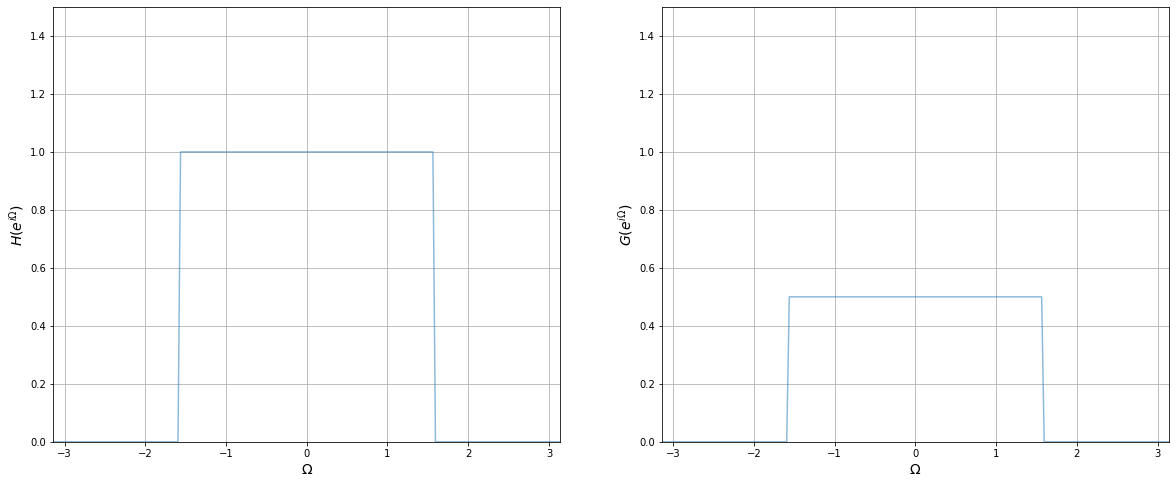

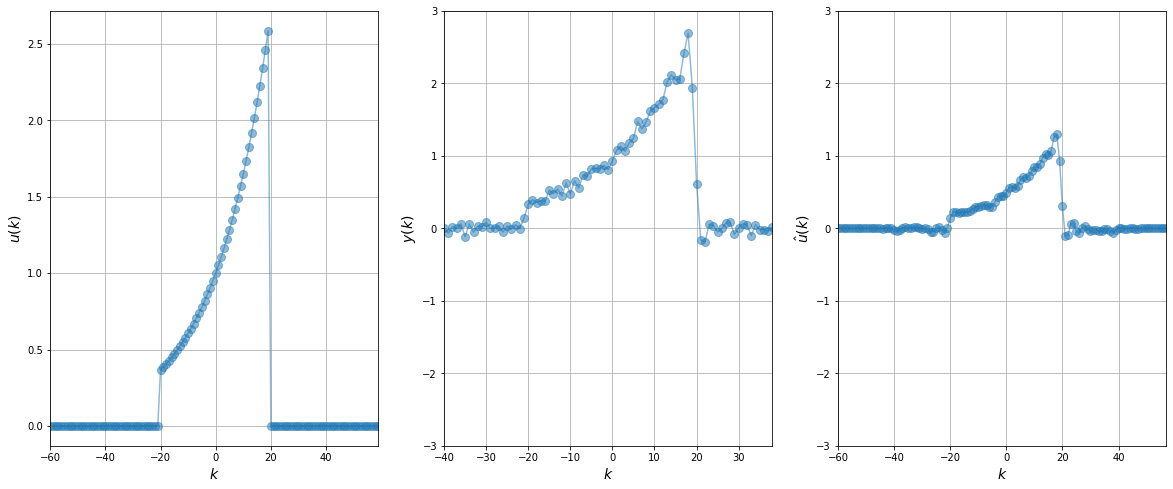

In [227]:
plot()
plot_time()